# Movie plot processing
We're reading a dataset containing movie summaries (`movies_metadata.csv` downloaded from https://www.kaggle.com/rounakbanik/the-movies-dataset). In the end, we want to have the titles, summaries and their corresponding embeddings for some well-known movies.

In [1]:
import pandas as pd
import numpy as np
import spacy
from sklearn.decomposition import PCA
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
original = pd.read_csv('original.csv', low_memory=False)
print(f'example summary: {original["overview"][0]}')
print(f'number of movies: {len(original)}')

example summary: Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy's heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their differences.
number of movies: 45466


In [3]:
numeric = pd.DataFrame(original)
numeric['popularity'] = pd.to_numeric(numeric['popularity'], errors='coerce')

In [4]:
popular = numeric.nlargest(1024, 'popularity')

In [5]:
processed = pd.DataFrame()
processed['title'] = popular['original_title']
processed['summary'] = popular['overview']

In [6]:
processed.head()

,title,summary
30700,Minions,"Minions Stuart, Kevin and Bob are recruited by..."
33356,Wonder Woman,An Amazon princess comes to the world of Man t...
42222,Beauty and the Beast,A live-action adaptation of Disney's version o...
43644,Baby Driver,After being coerced into working for a crime b...
24455,Big Hero 6,The special bond that develops between plus-si...


In [7]:
def harry_potter(df):
    locations = df['title'].str.contains('Harry Potter')
    return df.loc[locations]

In [8]:
harry_potter(processed)

,title,summary
4766,Harry Potter and the Philosopher's Stone,Harry Potter has lived under the stairs at his...
5678,Harry Potter and the Chamber of Secrets,"Ignoring threats to his life, Harry returns to..."
7725,Harry Potter and the Prisoner of Azkaban,"Harry, Ron and Hermione return to Hogwarts for..."
17437,Harry Potter and the Deathly Hallows: Part 2,"Harry, Ron and Hermione continue their quest t..."
10554,Harry Potter and the Goblet of Fire,"Harry starts his fourth year at Hogwarts, comp..."
16128,Harry Potter and the Deathly Hallows: Part 1,"Harry, Ron and Hermione walk away from their l..."
11927,Harry Potter and the Order of the Phoenix,Returning for his fifth year of study at Hogwa...
13893,Harry Potter and the Half-Blood Prince,"As Harry begins his sixth year at Hogwarts, he..."


In [9]:
processed = processed.drop_duplicates(subset='title')
processed = processed.drop_duplicates(subset='summary')

In [10]:
harry_potter(processed)

,title,summary
4766,Harry Potter and the Philosopher's Stone,Harry Potter has lived under the stairs at his...
5678,Harry Potter and the Chamber of Secrets,"Ignoring threats to his life, Harry returns to..."
7725,Harry Potter and the Prisoner of Azkaban,"Harry, Ron and Hermione return to Hogwarts for..."
17437,Harry Potter and the Deathly Hallows: Part 2,"Harry, Ron and Hermione continue their quest t..."
10554,Harry Potter and the Goblet of Fire,"Harry starts his fourth year at Hogwarts, comp..."
16128,Harry Potter and the Deathly Hallows: Part 1,"Harry, Ron and Hermione walk away from their l..."
11927,Harry Potter and the Order of the Phoenix,Returning for his fifth year of study at Hogwa...
13893,Harry Potter and the Half-Blood Prince,"As Harry begins his sixth year at Hogwarts, he..."


In [11]:
len(processed)

1014

In [12]:
lengths = processed['summary'].map(len)
processed = processed.loc[lengths > 64]

In [13]:
harry_potter(processed)

,title,summary
4766,Harry Potter and the Philosopher's Stone,Harry Potter has lived under the stairs at his...
5678,Harry Potter and the Chamber of Secrets,"Ignoring threats to his life, Harry returns to..."
7725,Harry Potter and the Prisoner of Azkaban,"Harry, Ron and Hermione return to Hogwarts for..."
17437,Harry Potter and the Deathly Hallows: Part 2,"Harry, Ron and Hermione continue their quest t..."
10554,Harry Potter and the Goblet of Fire,"Harry starts his fourth year at Hogwarts, comp..."
16128,Harry Potter and the Deathly Hallows: Part 1,"Harry, Ron and Hermione walk away from their l..."
11927,Harry Potter and the Order of the Phoenix,Returning for his fifth year of study at Hogwa...
13893,Harry Potter and the Half-Blood Prince,"As Harry begins his sixth year at Hogwarts, he..."


In [14]:
len(processed)

1012

## It's embedding time!

In [15]:
nlp = spacy.load('en_core_web_lg')

In [16]:
summary_vectors = [nlp(summary).vector for summary in processed['summary']]
print(f'example vector: {summary_vectors[0].dtype}, len: {len(summary_vectors[0])}')

example vector: float32, len: 300


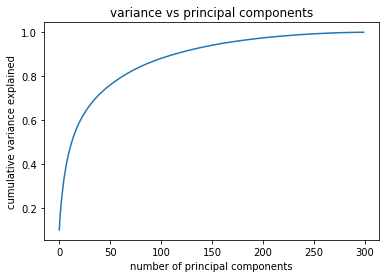

In [17]:
pca = PCA().fit(summary_vectors)
plt.title('variance vs principal components')
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of principal components')
plt.ylabel('cumulative variance explained')
plt.show()

Seems like we can use the 64 first principal components for a decent trade-off.

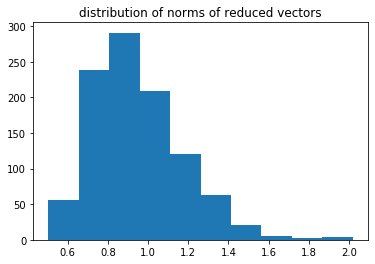

In [18]:
summary_vectors_reduced = pca.transform(summary_vectors)
plt.title('distribution of norms of reduced vectors')
plt.hist([np.linalg.norm(vector) for vector in summary_vectors_reduced])
plt.show()

In [21]:
processed['vector'] = list(summary_vectors_reduced)
harry_potter(processed)

,title,summary,vector
4766,Harry Potter and the Philosopher's Stone,Harry Potter has lived under the stairs at his...,"[-0.23976451058209547, 0.2751888379038316, -0...."
5678,Harry Potter and the Chamber of Secrets,"Ignoring threats to his life, Harry returns to...","[0.42926519982834355, 0.10319561763565809, -0...."
7725,Harry Potter and the Prisoner of Azkaban,"Harry, Ron and Hermione return to Hogwarts for...","[0.2415661298185778, 0.2537221023699368, 0.274..."
17437,Harry Potter and the Deathly Hallows: Part 2,"Harry, Ron and Hermione continue their quest t...","[0.2052952980150255, 0.07887802664689465, 0.16..."
10554,Harry Potter and the Goblet of Fire,"Harry starts his fourth year at Hogwarts, comp...","[0.45008406825314656, 0.26288261303922744, 0.1..."
16128,Harry Potter and the Deathly Hallows: Part 1,"Harry, Ron and Hermione walk away from their l...","[0.24198656336714344, 0.1526582054818701, 0.26..."
11927,Harry Potter and the Order of the Phoenix,Returning for his fifth year of study at Hogwa...,"[0.00028371150767723605, -0.07694055172516309,..."
13893,Harry Potter and the Half-Blood Prince,"As Harry begins his sixth year at Hogwarts, he...","[0.06337336067400161, 0.20558385312643662, 0.0..."


In [22]:
processed.to_csv('processed.csv', index=False)